In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

# Easy

In [2]:
data = pd.read_pickle("../data/train.pickle")
labels = pd.read_csv('../data/label_names.csv').SignName

In [3]:
X = data['features'].astype(np.float32) / 255.0
y = data['labels'] 
sizes = data['sizes']
coords = data['coords']

In [4]:
print(f"x_shape={X.shape}\ny_shape={y.shape}")

x_shape=(34799, 32, 32, 3)
y_shape=(34799,)


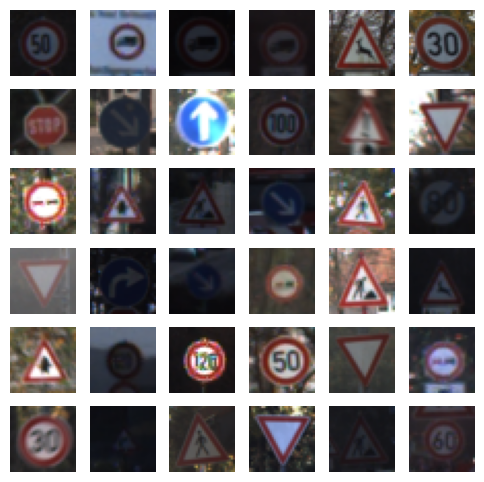

In [5]:
plt.figure(figsize=(6, 6))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.imshow(X[random.randint(0, len(X) - 1)])
    plt.axis("off")
    
plt.show()

In [6]:
X = X.reshape(X.shape[0], -1)
print(f"X_shape={X.shape}")

X_shape=(34799, 3072)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 ### Preprocessing data

In [8]:
min_max_scaler_train = preprocessing.MinMaxScaler()
X_train = min_max_scaler_train.fit_transform(X_train)

min_max_scaler_test = preprocessing.MinMaxScaler()
X_test = min_max_scaler_test.fit_transform(X_test)

### Training

In [9]:
linear_model = LogisticRegression(max_iter=500)

In [10]:
linear_model.fit(X=X_train, y=y_train)

LogisticRegression(max_iter=500)

### Prediction & Score

To determine which metric to use, let's have a look at a distribution of classes

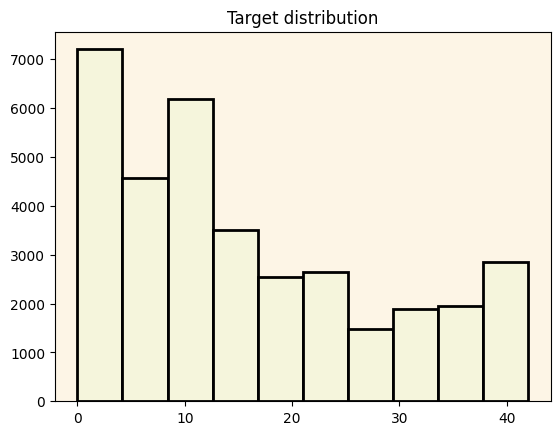

In [11]:
fig, ax = plt.subplots()
plt.hist(x=y, color="beige", edgecolor="black", linewidth=2.0)
ax.set_title("Target distribution")
ax.set_facecolor("oldlace")

plt.show()

Since we are dealing with imbalanced classification, it's better to use ```balanced_accuracy_score```

In [12]:
predictions = linear_model.predict(X_test)

In [13]:
balanced_accuracy_score(y_pred=predictions, y_true=y_test)

0.94755732214114

In [14]:
conf_matrix = confusion_matrix(y_pred=predictions, y_true=y_test)

In [15]:
# 'errors_max' shows the maximum amount of times that some sign was misrecognized with others.
y_errors = dict()
for i in range(len(conf_matrix)):
    errors = 0
    for k in range(len(conf_matrix)):
        if k == i:
            continue
        else:
            errors+= conf_matrix[i][k]
    y_errors[labels[i]] = errors 
    
top_5_errors = dict(sorted(y_errors.items(), key=lambda item: item[1], reverse=True)[:5])
top_5_errors

{'Speed limit (80km/h)': 30,
 'Speed limit (30km/h)': 25,
 'Speed limit (70km/h)': 25,
 'Speed limit (50km/h)': 20,
 'Speed limit (60km/h)': 16}

There are different speed limit signs that resemble each other.

Probably, we should create model_2 and train it specifically on speed limit signs. 

Afterward, we can use model_2 when our first model identifies that it's one of the speed limit signs.

# Medium

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [17]:
models = [MultinomialNB(), KNeighborsClassifier(n_neighbors=5), LogisticRegression(max_iter=500), 
          SVC(kernel='linear'), SVC(kernel='poly'), SVC(kernel='rbf')]

In [18]:
cross_val_accuracies = dict()

In [19]:
for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cross_val_accuracies[f"{model}"] = scores
    print(f"{model}: {scores}\n====\n")

MultinomialNB(): [0.34177443 0.32974138 0.3441092  0.33764368 0.33806359]
====

KNeighborsClassifier(): [0.85650144 0.85111351 0.86350575 0.8518319  0.85306269]
====

LogisticRegression(max_iter=500): [0.94827586 0.94791667 0.95474138 0.94971264 0.95724807]
====

SVC(kernel='linear'): [0.95474138 0.95689655 0.95941092 0.95240661 0.96191845]
====

SVC(kernel='poly'): [0.66325431 0.68193247 0.68336925 0.68049569 0.69175498]
====

SVC(): [0.85488506 0.86117098 0.85506466 0.86099138 0.86222382]
====



In [20]:
from scipy.stats import ttest_ind

In [21]:
models_names = list(cross_val_accuracies.keys())

In [22]:
for i in range(len(models_names)):
    for j in range(i + 1, len(models_names)):
        pvalue = ttest_ind(cross_val_accuracies[models_names[i]], cross_val_accuracies[models_names[j]], alternative='greater').pvalue
        if pvalue < 0.05:
            print(f"{models_names[i]} > {models_names[j]}")
        
        pvalue = ttest_ind(cross_val_accuracies[models_names[i]], cross_val_accuracies[models_names[j]], alternative='less').pvalue
        if pvalue < 0.05:
            print(f"{models_names[i]} < {models_names[j]}")

MultinomialNB() < KNeighborsClassifier()
MultinomialNB() < LogisticRegression(max_iter=500)
MultinomialNB() < SVC(kernel='linear')
MultinomialNB() < SVC(kernel='poly')
MultinomialNB() < SVC()
KNeighborsClassifier() < LogisticRegression(max_iter=500)
KNeighborsClassifier() < SVC(kernel='linear')
KNeighborsClassifier() > SVC(kernel='poly')
LogisticRegression(max_iter=500) < SVC(kernel='linear')
LogisticRegression(max_iter=500) > SVC(kernel='poly')
LogisticRegression(max_iter=500) > SVC()
SVC(kernel='linear') > SVC(kernel='poly')
SVC(kernel='linear') > SVC()
SVC(kernel='poly') < SVC()


<b>Conclusion: ```SVC(kernel='linear')``` is the best model</b>

<b>```MultinomialNB```</b> is the worst model because it assumes that all pixels of an image are independent,<br>
which definetly is not true